In [85]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count
from numba import jit
import copy
import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16


In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))
    
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

In [5]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

# Часть Первая
### Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [6]:
def getAction(env,Q,state,ES,epsilon):
   # _, ES,_ = env.getState()
    if np.random.uniform(0, 1) > epsilon and state in Q:
        return np.argmax(Q[state],axis=0)
    else:
        if state not in Q:
            Q[state] = np.zeros(len(ES))
        return np.random.choice(len(ES))
    
def selectQ(curTurn):
    return Q_X if curTurn==1 else Q_O


def selectPrevState(curTurn):
    return prevState_X if curTurn==1 else prevState_O

def selectPrevAction(curTurn):
    return prevAction_X if curTurn==1 else prevAction_O

def learn(env, Q1, Q2, alpha=1e-3,epsilon=0.1,gamma=1):
    #state = env.reset()
    env.reset()
    prevState, ES,curTurn = env.getState()
    
    prevState_X=None
    prevState_X=None
    prevAction_O=None
    prevAction_X=None
    curState1=None
    curState2=None
    is_done=False
    
    while not is_done:
        if curTurn==1:
            
            action=getAction(env,Q1,prevState,ES,epsilon)
            new_state, reward, is_done, _ = env.step(ES[action])
            curState, emptySpaces,curTurn = new_state
            assert reward !=-10
            if reward==1:
                Q1[prevState][action]=reward
        
            if prevState_O is not None:
                if curState in Q2:
                    Q_max=np.max(Q2[curState], axis=0)
                else:
                    Q_max=0
        
                Q2[prevState_O][prevAction_O] = Q2[prevState_O][prevAction_O] + alpha * (-reward + gamma*Q_max - Q2[prevState_O][prevAction_O]) 
            prevAction_X=action
            prevState_X=prevState
            
        elif curTurn==-1:
            action=getAction(env,Q2,prevState,ES,epsilon)
            new_state, reward, is_done, _ = env.step(ES[action])
            curState, emptySpaces,curTurn = new_state
            curState2=curState;
           #     Q1[curState]=np.zeros(3**2)
            assert reward !=-10
            if reward==-1:
                Q2[prevState][action]=-reward
            if prevState_X is not None:
                if curState in Q1:
                    Q_max=np.max(Q1[curState], axis=0)
                else:
                    Q_max=0
        
                Q1[prevState_X][prevAction_X] = Q1[prevState_X][prevAction_X] + alpha * (reward + gamma*Q_max - Q1[prevState_X][prevAction_X]) 
 
            prevAction_O=action
            prevState_O=prevState
            
        ES=emptySpaces; prevState=curState
            

In [33]:
def playQ_crosses(env, Q_X,  test_episodes=1000):
    rewards=[]
    for _ in range(test_episodes):
        env.reset()
        prevState, ES,curTurn = env.getState()
        is_done = False
        
        while not is_done:

            if curTurn == 1:
                if prevState in Q_X:
                    action = np.argmax(Q_X[prevState],axis=0)
                else:
                    action = np.random.choice(len(ES))
                new_state, reward, is_done, _ = env.step(ES[action])

                curState, emptySpaces, curTurn = new_state
                
            elif curTurn == -1:
                
                action = np.random.choice(len(ES))
                new_state, reward, is_done, _ = env.step(ES[action])

                curState, emptySpaces, curTurn = new_state

            prevState=curState
            ES=emptySpaces
            
        rewards.append(reward)
        
    return rewards


def playQ_naughts(env, Q_O, test_episodes=1000):
    rewards=[]
    for _ in range(test_episodes):
        env.reset()
        prevState, ES,curTurn = env.getState()
        is_done = False
        
        while not is_done:

            if curTurn == 1:
                action = np.random.choice(len(ES))
                new_state, reward, is_done, _ = env.step(ES[action])

                curState, emptySpaces, curTurn = new_state
                
            elif curTurn == -1:
                
                if prevState in Q_O:
                    action = np.argmax(Q_O[prevState],axis=0)
                else:
                    action = np.random.choice(len(ES))
                new_state, reward, is_done, _ = env.step(ES[action])

                curState, emptySpaces, curTurn = new_state

            prevState=curState
            ES=emptySpaces
        
        rewards.append(reward)
        
    return rewards



In [112]:
Q_X={}
Q_O={}

env = TicTacToe(3, 3, 3)
learning_episodes = 100000
play_episodes = 500
crosses_mean_results = []
noughts_mean_results = []

for i in tqdm(range(learning_episodes)):
    learn(env, Q_X, Q_O, alpha=0.05, epsilon=0.5)
    if i % 1000 == 0:
        crosses = playQ_crosses(env, Q_X, play_episodes)
        noughts = playQ_naughts(env, Q_O, play_episodes)
        crosses_mean_results.append(np.mean(crosses))
        noughts_mean_results.append(-np.mean(noughts))
    else:
        crosses_mean_results.append(np.mean(crosses))
        noughts_mean_results.append(-np.mean(noughts))

100%|██████████| 100000/100000 [01:36<00:00, 1030.96it/s]


#### Построим график обучения игры против рандомной стратегии для 100к обучающих эпизодов с усреднением по 500 играм

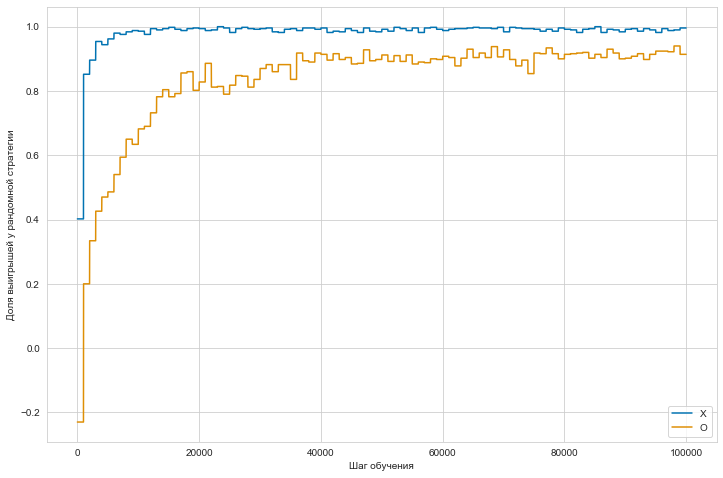

In [113]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(crosses_mean_results)), crosses_mean_results, label='X')
plt.plot(range(len(crosses_mean_results)), noughts_mean_results, label='O')
plt.xlabel("Шаг обучения")
plt.ylabel("Доля выигрышей у рандомной стратегии")
plt.legend()

### 2. Обучим для 4х4

In [114]:
Q_X={}
Q_O={}

env = TicTacToe(4, 4, 4)
learning_episodes = 500000
play_episodes = 500
crosses_mean_results = []
noughts_mean_results = []

for i in tqdm(range(learning_episodes)):
    learn(env, Q_X, Q_O, alpha=0.05, epsilon=0.5)
    if i % 2500 == 0:
        crosses = playQ_crosses(env, Q_X, play_episodes)
        noughts = playQ_naughts(env, Q_O, play_episodes)
        crosses_mean_results.append(np.mean(crosses))
        noughts_mean_results.append(-np.mean(noughts))
    else:
        crosses_mean_results.append(np.mean(crosses))
        noughts_mean_results.append(-np.mean(noughts))

100%|██████████| 500000/500000 [14:56<00:00, 557.43it/s] 


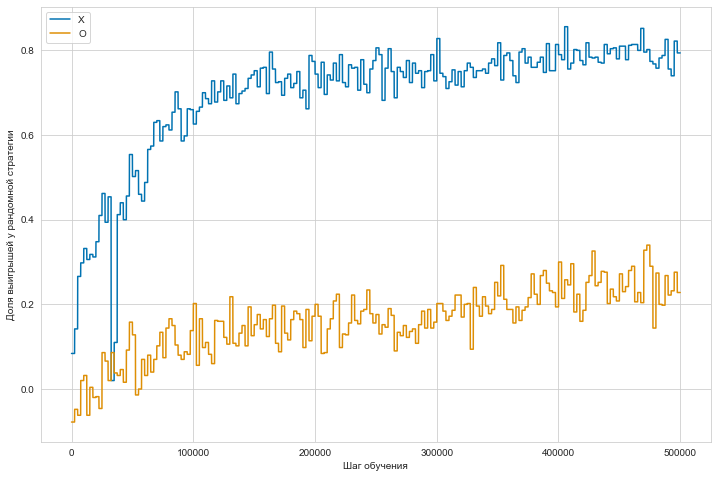

In [115]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(crosses_mean_results)), crosses_mean_results, label='X')
plt.plot(range(len(crosses_mean_results)), noughts_mean_results, label='O')
plt.xlabel("Шаг обучения")
plt.ylabel("Доля выигрышей у рандомной стратегии")
plt.legend()